In [1]:
import numpy as np
import torch
import torch.nn as nn
import os, sys, time
import uproot3 as uproot
import pandas as pd
import matplotlib.pyplot as plt
from numbers import Integral
from scipy.optimize import curve_fit
from scipy.stats import norm, truncnorm, foldnorm
import warnings
from time import perf_counter
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler

warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 16

print('Uproot version:',uproot.version.version)
print('Numpy version:', np.version.version)
print('Pandas version:', pd.__version__)
plt.ioff()

# инициализация генератора псевдослучайных чисел
# pandas version was 1.5.1

rng = np.random.default_rng(42069) # сделать другой был 12345

Uproot version: 3.14.4
Numpy version: 1.26.1
Pandas version: 2.0.3


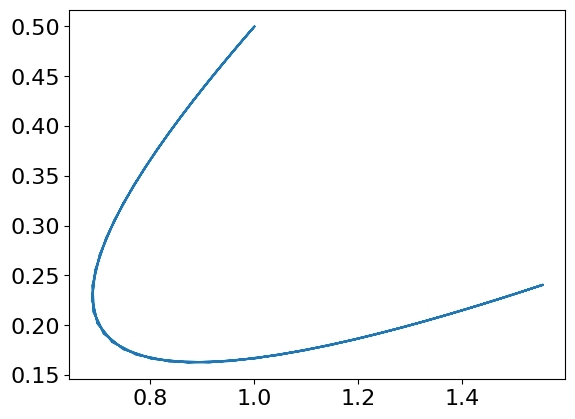

In [4]:
r = 1 / 3
s = np.sin(np.linspace(0, 2*np.pi, 100))
R_1 = 1/2 - s*s+5/9*(s**4)+5/9*(s**4)*r
R_2 = (1/2 - 2/3*s*s)**2+1/9*(s**4)+1/r*((1/2-1/3*s*s)**2 + 4/9*(s**4))
plt.plot(R_2, R_1)
plt.show()

In [3]:
t1 = torch.tensor([1 , 2 ,3])
t2 = torch.tensor([4])
torch.cat((t1, t2))

tensor([1, 2, 3, 4])

In [4]:
datadir = 'data'
picsdir = 'pics'

In [5]:
filepath = os.path.join(datadir, 'farichsim_1200kevt.root')

In [6]:
def rms90(arr):
    # Calculate the mean and standard deviation of the array
    arr = arr.dropna()
    # arr_mean = np.mean(arr)
    # arr_std = np.std(arr)

    # Define the upper and lower limits for the 90% range
    lower_limit = np.percentile(arr, 5)
    upper_limit = np.percentile(arr, 95)
    # print(lower_limit, upper_limit)
    # print(arr)
    # Select the values within the 90% range
    arr_filtered = arr[(arr >= lower_limit) & (arr <= upper_limit)]
    # print(arr_filtered)
    assert arr_filtered.shape
    # Calculate the root mean square of the filtered values
    rms = np.std(arr_filtered)

    return rms

In [7]:
def readInfoFromRoot(filepath, verbose: bool = False) -> pd.DataFrame:
  '''
  Получение информации о моделировании из ROOT-файла в виде датафрейм формой (1, N), где N - число параметров.
  '''
  # Названия используемых колонок данных для переименования и сохранения в data frame
  idf_rename_map = {'m_num_events': 'nevents',  # число событий моделирования
                    'm_z_dis': 'zdis',  # расстояние от места рождения частицы до входа в радиатор в мм
                    'm_layers': 'nlayers',  # число слоев радиатора
                    'm_size': 'array_size',  # размер матрицы КФУ в мм
                    'm_gap': 'array_gap',  # зазор между матрицами КФУ в мм
                    'm_chip_size': 'pixel_size',  # размер пикселя КФУ в мм
                    'm_chip_pitch': 'pixel_gap',  # зазор между пикселями КФУ в мм
                    'm_chip_num_size': 'pixel_numx',  # размер матрицы КФУ в пикселях
                    'm_num_side_x': 'nxarrays', 'm_num_side_y': 'nyarrays',  # размер фотодетектора в матрицах КФУ по X и Y
                    'm_focal_length': 'distance',  # расстояние от входа в радиатор до входа в фотодетектор
                    'm_trg_window': 'trg_window_ns',  # размер временного окна в нс
                    'W': 'W',  # толщина радиатора в мм (вычисляемая)
                    'n_mean': 'n_mean',  # средний показатель преломления радиатора (вычисляемый)
                    'n_max': 'n_max',  # максимальный показатель преломления радиатора (вычисляемый)
                   }

  # Открытие ROOT-файла с данными используя Uproot https://github.com/scikit-hep/uproot3
  with uproot.open(filepath) as file:
    idf = file[b'info_sim'].pandas.df('*', flatten=False)

  # Переименование параметров
  idf.rename(columns=idf_rename_map, inplace=True, errors='ignore')

  # Получение параметров (многослойного) радиатора одинаковых для всех файлов
  n_l = idf.at[0,'m_layers.first']  # показатели преломления слоёв
  w_l = idf.at[0,'m_layers.second']  # толщины слоёв радиатора

  W = w_l.sum()  # суммарная толщина всех слоёв
  n_mean = n_l.mean()  # средний показатель преломления
  n_max = n_l.max()  # максимальный показатель преломления

  # Добавление вычисляемых параметров в idf
  idf['W'] = W
  idf['n_mean'] = n_mean
  idf['n_max'] = n_max

  # Сохранение нужных параметров
  idf = idf[idf_rename_map.values()]

  if verbose:
    for name in idf.columns:
      print(f'{name}: {idf.at[0, name]}')

  return idf

In [8]:
idf = readInfoFromRoot(filepath)

In [9]:
def genChunkFromRoot(filepath, eventchunksize=2000, noisefreqpersqmm: float = 2e6, noiseTimeRange: float = (0, 7), shiftSignalTimes: bool = True,
                     edfstore: pd.HDFStore = None, verbose: bool = True, to_skip : int = 0) -> pd.DataFrame:
  """
    Генератор событий из ROOT-файла в виде датафрейма. Число событий eventchunksize, читаемых генератором за один раз, должен выбираться так,
    чтобы все данные с учетом добавляемых шумовых срабатываний умещались в размер ОЗУ.

    Параметры:
    filepath - путь к ROOT-файлу для чтения.
    eventchunksize - число событий, загружаемых из ROOT-файла за один вызов.
    noisefreqpersqmm - частота темновых срабатываний на единицу активной площади фотодетектора в с^{-1}*мм^{-2}, подмешиваемых к событиям;
                       максимальное значение параметра, которое имеет смысл рассматривать, 2e6.
    noiseTimeRange - (start, stop) - tuple, задающий временной интервал генерации шума в наносекундах.
    edfstore - HDF-хранилище для записи датафрейма "edf"; данные добавляются к уже записанным в хранилище.
    verbose - флаг отладочной печати.

    Описание условий моделирования:
    Ось Z направлена по нормали к плоскости радиатора от радиатора к фотодетектору.
    Оси X и Y паралельны осям симметрии матрицы фотодетектора.
    Первичная частица (отрицательный пион) вылетает на расстоянии zdis=1 мм перед радиатором в его сторону
    Начальное положение частицы случайно разбрасывается по X и Y в квадрате со стороной (pixel_size+pixel_gap).
    Направление частицы случайно разбрасывается в телесном угле в пределах theta_p=[0, π/4], phi_p=[0, 2π].
    Скорость частицы случайно и равномерно разбрасывается от 0.957 до 0.999 скорости света.
  """
  global rng

  # Данные о частице (для переименования и сохранения)
  part_rename_map = {'m_hits': 'nhits',                # число срабатываний в событии
                     'm_pos_primary._0': 'x_p',        # X-координата вылета частицы в мм
                     'm_pos_primary._1': 'y_p',        # Y-координата вылета частицы в мм
                     'm_pos_primary._2': 'z_p',        # Z-координата вылета частицы в мм
                     'm_dir_primary._0': 'nx_p',       # X-компонента единичного вектора направления частицы
                     'm_dir_primary._1': 'ny_p',       # Y-компонента единичного вектора направления частицы
                     'm_dir_primary._2': 'nz_p',       # Z-компонента единичного вектора направления частицы
                     'm_beta_primary': 'beta',         # скорость частицы в единицах скорости света
                     'm_theta_primary': 'theta_p',     # полярный угол направления частицы в радианах
                     'm_phi_primary': 'phi_p',         # азимутальный угол направления частицы в радианах
                     'm_momentum_primary': 'momentum'  # импульс частицы в МэВ/c
                    }

  # Наблюдаемые данные о срабатываниях (для переименования и сохранения)
  hit_rename_map = {'m_hits.m_photon_pos_chip._0': 'x_c',  # X-координата срабатывания в мм
                    'm_hits.m_photon_pos_chip._1': 'y_c',  # Y-координата срабатывания в мм
                    'm_hits.m_photon_pos_chip._2': 'z_c',  # Z-координата срабатывания в мм
                    'm_hits.m_photon_time': 't_c'          # время срабатывания в нс
                   }



  # Наименования колонок для сохранения в датафрейм
  edfcolstosave = list(part_rename_map.values()) + list(hit_rename_map.values())

  # Чтение параметров моделирования
  idf = readInfoFromRoot(filepath)

  # Определения параметров фотодетектора для генерации темнового шума
  pixel_size, pixel_gap = idf.at[0, 'pixel_size'], idf.at[0, 'pixel_gap']
  array_size, array_gap = idf.at[0, 'array_size'], idf.at[0, 'array_gap']
  nxpixels_arr = idf.at[0, 'pixel_numx']
  nxpixels_tot = idf.at[0, 'nxarrays']*nxpixels_arr
  igrid = np.arange(nxpixels_tot//2)
  xpnts = array_gap/2 + (igrid//nxpixels_arr)*(array_size+array_gap) + (igrid%nxpixels_arr)*(pixel_size+pixel_gap) + pixel_size/2
  xpnts = np.sort(np.append(-xpnts, xpnts)).astype('float32')
  xgrid, ygrid = np.meshgrid(xpnts, xpnts)
  xgrid = xgrid.reshape(xgrid.size)
  ygrid = ygrid.reshape(ygrid.size)

  def addNoise(partdf: pd.DataFrame, hitdf: pd.DataFrame) -> pd.DataFrame:
    '''
    Генерация темновых срабатываний темнового шума и добавление в датафрейм (без учета "мёртвого" времени пикселя).
    partdf - датафрейм для частиц
    hitdf - датафрейм для срабатываний
    '''
    assert(np.isclose(pixel_size*nxpixels_arr+pixel_gap*(nxpixels_arr-1), array_size))
    nevents = partdf.shape[0]  # число событий

    # среднее число шумовых срабатываний на событие
    munoise = (noiseTimeRange[1]-noiseTimeRange[0])*1e-9*noisefreqpersqmm*(pixel_size**2)*(nxpixels_tot**2)

    print(f'    Generate noise with DCR per mm^2 {noisefreqpersqmm}, mean number of hits per event: {munoise:.2f}.', end='')

    noisehits = rng.poisson(munoise, nevents)   # генерация массива числа шумовых срабатываний в событиях по пуассоновскому распределению
    Ndc = int(noisehits.sum())                  # общее число шумовых срабатываний (скаляр)
    signalhits = partdf['nhits'].to_numpy()     # массив числа сигнальных срабатываний по событиям

    # случайное смещение сигнальных срабатываний в пределах временного окна генерации шума
    if shiftSignalTimes:
      hitdf['t_c'] += np.repeat(rng.uniform(0, noiseTimeRange[1]-2, nevents), partdf['nhits'])

    hitdf['signal'] = np.ones(signalhits.sum(), bool)  # разметка сигнальных срабатываний значением 'signal' True
    if Ndc == 0:    # если нет шумовых срабатываний
      return hitdf  # возвращаем исходный датафрейм с добавлением колонки 'signal'

    ich = rng.choice(xgrid.size, Ndc)           # генерация случайных номеров сработавших каналов с возможным повтором
    xh = xgrid[ich]                             # x-координата сработавших каналов
    yh = ygrid[ich]                             # y-координата сработавших каналов
    # zh = hitdf.at[(0, 0), 'z_c']                # z-координата срабатываний (скаляр)
    zh = 201.050003
    th = rng.uniform(noiseTimeRange[0], noiseTimeRange[1], size=Ndc) # генерация времён срабатываний по однородному распределению

    # нумерация шумовых срабатываний по событиям
    ievent = np.repeat(partdf.index, noisehits) # массив номеров событий для записи в датафрейм
    ihit = np.zeros(Ndc, 'int64')               # инициализация массива номеров срабатываний для записи в датафрейм
    index = 0
    for i in range(nevents):
      ihit[index:index+noisehits[i]] = signalhits[i] + np.arange(noisehits[i])
      index += noisehits[i]

    # создание датафрейма с шумовыми срабатываниями того же формата, что hitdf
    noisedf = pd.DataFrame({'x_c': xh, 'y_c': yh, 'z_c': zh, 't_c': th, 'signal': np.zeros(Ndc, bool)},
                           index=pd.MultiIndex.from_arrays((ievent, ihit), names=('entry', 'subentry')))

    # TO DO: случайное смещение кольца в фотодетекторе (сдвиг координат сигнальных хитов).
    # Сложность с реализацией для неравномерной сетки пикселей, т.к. зазоры между матрицами больше зазоров между пикселями в матрице.
    # Проще сделать в моделировании.

    # сливаем сигнальный и шумовой датафрейм и сортируем указатель событий и срабатываний
    hitdf2 = pd.concat((hitdf, noisedf), copy=False).sort_index(level=('entry', 'subentry'))

    # обновляем количества срабатываний в partdf, добавляя количества шумовых срабатываний по событиям
    partdf['nhits'] += noisehits

    return hitdf2


  nFileEvents = idf.at[0, 'nevents']
  # print(f'Processing ROOT file {filepath} with {nFileEvents} simulated events...', flush=True)
  skip_iterator = 0
  # Цикл чтения кусков ROOT-файла
  for partdf, hitdf in zip(uproot.pandas.iterate(filepath, "raw_data", part_rename_map.keys(), entrysteps=eventchunksize),
                           uproot.pandas.iterate(filepath, "raw_data", hit_rename_map.keys(), entrysteps=eventchunksize, flatten=True)):
    # print('\n  Processing next chunk...')
    if to_skip > skip_iterator:
      skip_iterator += 1
      yield 0
    else:
      # Переименование колонок
      partdf.rename(columns=part_rename_map, inplace=True, errors='raise')
      hitdf.rename(columns=hit_rename_map, inplace=True, errors='raise')

      partdf = partdf.astype('float32', copy=False)
      partdf['nhits'] = partdf['nhits'].astype('int32', copy=False)
      hitdf = hitdf.astype('float32', copy=False)

      # Генерация и добавление шумовых срабатываний
      hitdf = addNoise(partdf, hitdf)

      # print(f'    {hitdf.index.levels[0].size} entries with {hitdf.shape[0]} hits to process')

      # Слияние данных событий и срабатываний
      edf = hitdf.join(partdf, on='entry')
      #edf = hitdf.join(partdf, on='entry')
      #edf = edf.join(otherdf, on='entry')
      if verbose:
        pass
        # print(edf)

      if edfstore is not None:
        # print(f'    Saving edf chunk...')
        edfstore.put('edf', edf, format='table', append=True)

      yield edf

In [10]:
def recoAngles(edf: pd.DataFrame, idf: pd.DataFrame, rotation_mode = False):
  '''
  Геометрическая реконструкция углов фотонов относительно направления частицы.
  Из координат срабатываний и частиц вычисляются углы theta_c, phi_c и время вылета фотонов t_c_orig и добавляются к edf.
  '''
  r0 = edf.loc[:, ('x_p', 'y_p', 'z_p')].to_numpy()
  if rotation_mode:
    r = edf.loc[:, ('rotated_x', 'rotated_y', 'rotated_z')].to_numpy()
    # n0 = edf.loc[:, ('rotated_nx_p', 'rotated_ny_p', 'rotated_nz_p')].to_numpy()
    n0 = edf.loc[:, ('recalculated_nx_p', 'recalculated_ny_p', 'recalculated_nz_p')].to_numpy()
  else:
    r  = edf.loc[:, ('x_c', 'y_c', 'z_c')].to_numpy()
    n0 = edf.loc[:, ('nx_p', 'ny_p', 'nz_p')].to_numpy()

  speedOfLight_mmperns = 299.792458 # мм/нс

  # расстояние от радиатора до детектора
  dist = float(idf['distance'])

  # толщина радиатора
  W = float(idf['W'])

  # расстояние от точки вылета частицы до входной плоскости радиатора
  rad_pos = float(idf['zdis'])

  # полное число срабатываний
  N = edf.shape[0]

  # координаты точки пересечения трека с ФД
  if not rotation_mode:
    y_i = r0[:,1] + (dist + rad_pos) * n0[:,1] / n0[:,2] # r0[:,1] + (dist + W + rad_pos) * n0[:,1] / n0[:,2]   #   r0[:,1] + (dist + rad_pos) * n0[:,1] / n0[:,2]
    x_i = r0[:,0] + (y_i - r0[:,1]) * n0[:,0] / n0[:,1] # r0[:,0] + (y_i - r0[:,1]) * n0[:,0] / n0[:,1]    #     r0[:,0] + (dist + rad_pos) * n0[:,0] / n0[:,2]
    edf['x_i'] = x_i
    edf['y_i'] = y_i
    edf['r_p_c'] = np.sqrt((r0[:,0] - x_i) ** 2 + (r0[:,1] - y_i) ** 2 + (r0[:,2] - r[:,2]) ** 2)
    edf['r_c'] = np.sqrt((x_i - edf['x_c']) ** 2 + (y_i - edf['y_c']) ** 2)

  if rotation_mode:
    n_mean = float(idf['n_mean'])

    edf['rotated_r_c'] = np.sqrt((edf['rotated_x_i'] - edf['rotated_x']) ** 2 + (edf['rotated_y_i'] - edf['rotated_y']) ** 2)

    rotated_r_c = edf['rotated_r_c'].to_numpy()
    # r_p_c = edf['r_p_c'].to_numpy()
    beta = edf['beta'].to_numpy()
    r_p_c = dist # or + W/2 ???

    edf['beta_from_true_r'] = np.sqrt(rotated_r_c ** 2 + r_p_c ** 2) / (n_mean * r_p_c)
    edf['true_r_from_beta'] = r_p_c * np.sqrt((n_mean * beta) ** 2 - 1)

    avg_betas = []
    for _, subentry in edf['beta_from_true_r'].groupby(level=0):
      avg_beta = subentry.mean()
      for __ in subentry:
        avg_betas.append(avg_beta)
    edf['beta_from_true_r_mean'] = avg_betas
  # косинусы и синусы сферических углов направления частицы
  costheta, sintheta = n0[:,2], np.sqrt(n0[:,0]**2+n0[:,1]**2)
  phi = np.arctan2(n0[:,1], n0[:,0])
  cosphi, sinphi = np.cos(phi), np.sin(phi)

  # номинальная точка вылета фотонов
  ro = r0 + (W/2+rad_pos)/n0[:,2].reshape(N,1)*n0

  """
  Преобразование в СК частицы
  𝑢𝑥 = cos 𝜃(𝑣𝑥 cos 𝜙 + 𝑣𝑦 sin 𝜙) − 𝑣𝑧 sin 𝜃,
  𝑢𝑦 = −𝑣𝑥 sin 𝜙 + 𝑣𝑦 cos 𝜙,
  𝑢𝑧 = sin 𝜃(𝑣𝑥 cos 𝜙 + 𝑣𝑦 sin 𝜙) + 𝑣𝑧 cos 𝜃.
  """

  # вектор направления фотона в лабораторной СК
  s = (r-ro)
  snorm = np.linalg.norm(s, axis=1, keepdims=True)
  v = s / snorm
  if not rotation_mode:
    edf['t_c_orig'] = edf['t_c'] - (snorm / speedOfLight_mmperns).reshape(N)

  # освобождение памяти при необходимости
  #del r0, n0, ro, r, s

  U = np.stack((np.stack((costheta*cosphi, costheta*sinphi, -sintheta)),
                np.stack((-sinphi,         cosphi,          np.full(N, 0.))),
                np.stack((sintheta*cosphi, sintheta*sinphi, costheta)))).transpose(2,0,1)

  # единичный вектор направления фотона в СК частицы
  u = (U @ v.reshape(N,3,1)).reshape(N,3)

  # сферические углы фотона в СК частицы
  if rotation_mode:
    edf['rotated_theta_c'] = np.arccos(u[:,2])
    edf['rotated_phi_c'] = np.arctan2(-u[:,1], -u[:,0])
  else:
    edf['theta_c'] = np.arccos(u[:,2])
    edf['phi_c'] = np.arctan2(-u[:,1], -u[:,0])
    avg_thetas = []
    for _, subentry in edf['theta_c'].groupby(level=0):
      avg_theta = subentry.mean()
      for __ in subentry:
        avg_thetas.append(avg_theta)
    edf['theta_c_mean'] = avg_thetas

In [11]:
def applySpaceCut(edf: pd.DataFrame) -> pd.DataFrame:
  return edf[(abs(edf['x_c'] - edf['x_i']) <= 220) & (abs(edf['y_c'] - edf['y_i']) <= 220)]

In [12]:
def planeRecalculation(edf: pd.DataFrame, idf: pd.DataFrame):
    R_p = edf[['x_p', 'y_p', 'z_p']].to_numpy()
    R = edf[['x_c', 'y_c', 'z_c']].to_numpy()
    R_i = edf[['x_i', 'y_i', 'z_c']].to_numpy()
    N = edf[['nx_p', 'ny_p', 'nz_p']].to_numpy()
    dist = idf.W / 2 + idf.zdis
    alpha = (float(dist) - R_p[:,2]) / N[:,2]
    r_d = R_p + N * alpha[:, np.newaxis]

    u = R - r_d
    dot = np.sum(N * u, axis=1)
    w = r_d - R_i
    fac = -np.sum(N * w, axis=1) / dot
    u *= fac[:, np.newaxis]

    R_new = r_d + u

    speedOfLight_mmperns = 299.792458
    t_dif = np.sqrt(np.sum((R_new - R) ** 2, axis=1)) / speedOfLight_mmperns
    edf['t_c'] = edf['t_c'] + np.sign(R_new[:,2] - R[:,2]) * t_dif

    edf['recalculated_x'] = R_new[:,0]
    edf['recalculated_y'] = R_new[:,1]
    edf['recalculated_z'] = R_new[:,2]

In [13]:
def primaryDirectionRecalculation(edf: pd.DataFrame):
  N = edf.loc[:, ('nx_p', 'ny_p', 'nz_p')].to_numpy()
  M = []
  for n in N:
    # C = np.stack((np.array([-(n[1] ** 2 + n[2] ** 2) / n[0], 0 , n[0]]),
    #               np.array([n[1], - n[2], n[1]]),
    #               np.array([n[2], n[1], n[2]])))

    # C_inv = np.array([np.array([- n[0] / (n[0] ** 2 + n[1] ** 2 + n[2] ** 2), n[0] ** 2 * n[1] / (n[1] ** 4 + n[0] ** 2 * n[1] ** 2 + n[2] ** 4 + n[0] ** 2 * n[2] ** 2 + 2 * n[1] ** 2 * n[2] ** 2) , n[0] ** 2 * n[2] / (n[1] ** 4 + n[0] ** 2 * n[1] ** 2 + n[2] ** 4 + n[0] ** 2 * n[2] ** 2 + 2 * n[1] ** 2 * n[2] ** 2)]),
    #               np.array([0, - n[2] / (n[1] ** 2 + n[2] ** 2), n[1] / (n[1] ** 2 + n[2] ** 2)]),
    #               np.array([n[0] / (n[0] ** 2 + n[1] ** 2 + n[2] ** 2), n[1] / (n[0] ** 2 + n[1] ** 2 + n[2] ** 2), n[2] / (n[0] ** 2 + n[1] ** 2 + n[2] ** 2)])])
    M.append([0, 0, 1])
    # print(n)
    # print(C_inv)
    # print(C_inv @ n)
    # break
  M = np.array(M)
  edf['recalculated_nx_p'] = M[:,0]
  edf['recalculated_ny_p'] = M[:,1]
  edf['recalculated_nz_p'] = M[:,2]

In [14]:
def planeRotation(edf: pd.DataFrame):
  R = edf[['recalculated_x', 'recalculated_y', 'recalculated_z']].to_numpy()
  R_i = edf[['x_i', 'y_i', 'z_c']].to_numpy()
  N = edf[['nx_p', 'ny_p', 'nz_p']].to_numpy() # N
  M = np.array([0, 0, 1])                           # M
  c = np.dot(N, M) / (np.linalg.norm(M) * np.linalg.norm(N, axis=1))
  axis = np.cross(N, np.broadcast_to(M, (N.shape[0], 3))) / np.linalg.norm(np.cross(N, np.broadcast_to(M, (N.shape[0], 3))), axis=1, keepdims=True)
  x, y, z = axis.T
  s = np.sqrt(1-c*c)
  C = 1-c
  rmat = np.array([
      [x*x*C+c, x*y*C-z*s, x*z*C+y*s],
      [y*x*C+z*s, y*y*C+c, y*z*C-x*s],
      [z*x*C-y*s, z*y*C+x*s, z*z*C+c]])
  # print(rmat.shape)
  # print(R.shape)
  # print(rmat[:, :, 0])
  # print(R[0])
  # print(rmat[:, :, 0] @ R[0])
  rotated_R = np.matmul(rmat.transpose((2, 0, 1)), R[:, :, np.newaxis])
  rotated_R = np.squeeze(rotated_R, axis=-1).transpose().T
  rotated_R_i = np.matmul(rmat.transpose((2, 0, 1)), R_i[:, :, np.newaxis])
  rotated_R_i = np.squeeze(rotated_R_i, axis=-1).transpose().T
  # print(rotated_R[0])
  maskR = np.logical_or(abs(rotated_R[:, 0]) >= 500, abs(rotated_R[:, 1]) >= 500)
  maskR_i = np.logical_or(abs(rotated_R_i[:, 0]) >= 500, abs(rotated_R_i[:, 1]) >= 500)
  rotated_R[maskR] = [5000, 5000, 0]
  rotated_R_i[maskR_i] = [5000, 5000, 0]
  rotated_n = (rotated_R_i - edf[['x_p', 'y_p', 'z_p']].to_numpy()) / np.linalg.norm(rotated_R_i - edf[['x_p', 'y_p', 'z_p']].to_numpy(), axis=1, keepdims=True)
  edf['rotated_x'] = rotated_R[:,0]
  edf['rotated_y'] = rotated_R[:,1]
  edf['rotated_z'] = rotated_R[:,2]
  edf['rotated_x_i'] = rotated_R_i[:,0]
  edf['rotated_y_i'] = rotated_R_i[:,1]
  edf['rotated_z_i'] = rotated_R_i[:,2]
  edf['rotated_nx_p'] = rotated_n[:,0]
  edf['rotated_ny_p'] = rotated_n[:,1]
  edf['rotated_nz_p'] = rotated_n[:,2]

In [15]:
def applySecondSpaceCut(edf: pd.DataFrame) -> pd.DataFrame:
  return edf[(abs(edf['rotated_x'] - edf['rotated_x_i']) <= 220) & (abs(edf['rotated_y'] - edf['rotated_y_i']) <= 220)]

In [16]:
def beta_groups(df, num_of_groups=10):
    beta_step = np.ptp(df['beta'].values)
    beta_group = np.floor((num_of_groups * df['beta'] + max(df['beta']) - (num_of_groups + 1) * min(df['beta'])) / beta_step).values
    df['beta_group'] = beta_group
    beta_group = np.array([sub.iloc[0] for _, sub in df['beta_group'].groupby(level=0)])
    beta_group[beta_group == 0] = 1
    return beta_group

In [21]:
generator = genChunkFromRoot(filepath, 10000, noisefreqpersqmm=0)

In [41]:
edf = next(generator)

    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.

In [42]:
df = edf

In [44]:
df = df[df.theta_p <= 10 / 180 * np.pi]
recoAngles(df, idf) # TODO: add some more constraints from orig work
df = applySpaceCut(df)
planeRecalculation(df, idf)
planeRotation(df)
edf_d = applySecondSpaceCut(df)
primaryDirectionRecalculation(df)
recoAngles(df, idf, rotation_mode=True)
mask = np.logical_and(df.rotated_r_c >= 16, df.rotated_r_c <= 80)
df = df[mask]

In [35]:
df = df[df.theta_p <= 10 / 180 * np.pi]

In [45]:
df

x_c        y_c         z_c       t_c  signal  nhits  \
entry subentry                                                              
30027 2        -43.200001 -57.439999  201.050003  3.141336    True     28   
      3        -43.200001 -57.439999  201.050003  3.140838    True     28   
      4        -43.200001 -49.919998  201.050003  3.138927    True     28   
      5        -46.560001 -49.919998  201.050003  3.138936    True     28   
      6        -53.279999 -43.200001  201.050003  3.140759    True     28   
...                   ...        ...         ...       ...     ...    ...   
39981 38         5.440000  53.279999  201.050003  3.812229    True     45   
      39         5.440000  53.279999  201.050003  3.811216    True     45   
      40        12.160000  43.200001  201.050003  3.809696    True     45   
      41        18.879999  33.119999  201.050003  3.810063    True     45   
      42         8.800000  46.560001  201.050003  3.809343    True     45   

                     x_p       y_p  z_p      nx_p  ...  rotated_nz_p  \
entry subentry                                     ...                 
30027 2        -1.063744 -1.022151  0.0 -0.041498  ...           1.0   
      3        -1.063744 -1.022151  0.0 -0.041498  ...           1.0   
      4        -1.063744 -1.022151  0.0 -0.041498  ...           1.0   
      5        -1.063744 -1.022151  0.0 -0.041498  ...           1.0   
      6        -1.063744 -1.022151  0.0 -0.041498  ...           1.0   
...                  ...       ...  ...       ...  ...           ...   
39981 38       -1.089021 -0.468775  0.0 -0.129979  ...           1.0   
      39       -1.089021 -0.468775  0.0 -0.129979  ...           1.0   
      40       -1.089021 -0.468775  0.0 -0.129979  ...           1.0   
      41       -1.089021 -0.468775  0.0 -0.129979  ...           1.0   
      42       -1.089021 -0.468775  0.0 -0.129979  ...           1.0   

                recalculated_nx_p  recalculated_ny_p  recalculated_nz_p  \
entry subentry                                                            
30027 2                         0                  0                  1   
      3                         0                  0                  1   
      4                         0                  0                  1   
      5                         0                  0                  1   
      6                         0                  0                  1   
...                           ...                ...                ...   
39981 38                        0                  0                  1   
      39                        0                  0                  1   
      40                        0                  0                  1   
      41                        0                  0                  1   
      42                        0                  0                  1   

                rotated_r_c  beta_from_true_r  true_r_from_beta  \
entry subentry                                                    
30027 2           46.598687          0.982193         46.128288   
      3           46.598687          0.982193         46.128288   
      4           41.928399          0.977366         46.128288   
      5           44.509277          0.979973         46.128288   
      6           47.036440          0.982670         46.128288   
...                     ...               ...               ...   
39981 38          57.316016          0.995077         59.376804   
      39          57.316016          0.995077         59.376804   
      40          54.489620          0.991438         59.376804   
      41          54.321544          0.991227         59.376804   
      42          54.338391          0.991249         59.376804   

                beta_from_true_r_mean  rotated_theta_c  rotated_phi_c  
entry subentry                                                         
30027 2                      0.998839         0.247863       0.792367  
      3            

In [13]:
# edf[(edf.beta >= target_beta - 0.0001) & (edf.beta <= target_beta + 0.0001)]

In [14]:
# edf.loc[116]

In [15]:
# target_beta = 0.9957
# id = 116
#
# plt.scatter(edf.loc[116].x_c, edf.loc[id].y_c)
# plt.xlabel('X, mm')
# plt.ylabel('Y, mm')
# plt.title(f'p = 1500.8 MeV')
# plt.xlim((-200, 200))
# plt.ylim((-200, 200))
# plt.show()
# # edf[edf.beta == edf.beta.max()]

In [16]:
edf = edf[edf.theta_p <= 10 / 180 * np.pi]

In [17]:
i, j, k = 5, 5, 20
t_lims = (0, 8)
phi_lims = (-np.pi, np.pi)
theta_lims = (0, np.pi / 2)

In [18]:
def prepare_data(df, batch_size=64, shuffle=True):
    recoAngles(df, idf) # TODO: add some more constraints from orig work
    df = applySpaceCut(df)
    planeRecalculation(df, idf)
    planeRotation(df)
    df = applySecondSpaceCut(df)
    primaryDirectionRecalculation(df)
    recoAngles(df, idf, rotation_mode=True)
    mask = np.logical_and(df.rotated_r_c >= 16, df.rotated_r_c <= 80)
    df = df[mask]

    betas = df.beta
    betas = np.array([sub.iloc[0] for _, sub in betas.groupby(level=0)])

    theta_ps = df.theta_p
    theta_ps = np.array([sub.iloc[0] for _, sub in theta_ps.groupby(level=0)])

    df = df[['t_c_orig', 'phi_c', 'theta_c']]
    hist_3d = []
    for event in df.groupby(level=0):
        hist_3d.append(np.histogramdd(event[1].values, bins=(i, j, k), range=(t_lims, phi_lims, theta_lims))[0])
    hist_3d = np.array(hist_3d)
    hist_3d_flattened = np.array([hist.flatten() for hist in hist_3d])
    inputs = torch.cat((torch.tensor(hist_3d_flattened, dtype=torch.float32), torch.tensor(theta_ps[:, None])), dim=-1)
    outputs = torch.tensor(betas, dtype=torch.float32)
    dataset = TensorDataset(inputs, outputs)

    if batch_size == -1:
        batch_size = outputs.shape[0]

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [16]:
dataloader = prepare_data(edf)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(i*j*k+1, 1000)
        self.fc2 = nn.Linear(1000, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [22]:
dataloaders = []
for _ in range(100):
    tdf = next(generator)
    tdf = tdf[tdf.theta_p <= 10 / 180 * np.pi]
    dataloaders.append(prepare_data(tdf))

    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate

In [23]:
val_dataloaders = []
for _ in range(10):
    tdf = next(generator)
    tdf = tdf[tdf.theta_p <= 10 / 180 * np.pi]
    val_dataloaders.append(prepare_data(tdf))

    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.

In [24]:
device = 'cuda:0'

In [25]:
net = Net().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.1)


In [26]:
epochs = 300

In [27]:
losses = []
val_losses = []
epochss = []
best_loss = float('inf')
best_model_state = None
for epoch in range(epochs):
    for dataloader in dataloaders:
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = net(batch_inputs)  # Forward pass
            loss = criterion(outputs, batch_targets[:, None])  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights


    net.eval()
    with torch.no_grad():
        val_loss = 0.0
        length = 0
        for val_dataloader in val_dataloaders:
            for val_batch_inputs, val_batch_targets in val_dataloader:
                val_batch_inputs, val_batch_targets = val_batch_inputs.to(device), val_batch_targets.to(device)
                val_outputs = net(val_batch_inputs)
                val_loss += criterion(val_outputs, val_batch_targets[:, None]).item()
            length += len(val_dataloader)
        val_loss /= length
        val_losses.append(val_loss)
        net.train()

    scheduler.step()
    losses.append(loss.item())
    epochss.append(epoch)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = net.state_dict()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss}')

Epoch 1/300, Loss: 0.00041947641875594854, Val Loss: 0.00023529846828965033
Epoch 2/300, Loss: 0.0004387476365081966, Val Loss: 0.0001440945910069465
Epoch 3/300, Loss: 0.0001458621263736859, Val Loss: 0.0001238493965849878
Epoch 4/300, Loss: 0.0001225588785018772, Val Loss: 0.00010163980024277835
Epoch 5/300, Loss: 4.6766137529630214e-05, Val Loss: 3.52131843315232e-05
Epoch 6/300, Loss: 2.0412871890584938e-05, Val Loss: 1.8123935642138883e-05
Epoch 7/300, Loss: 1.7134279914898798e-05, Val Loss: 3.154167776462119e-05
Epoch 8/300, Loss: 1.7877913705888204e-05, Val Loss: 1.7534938806019295e-05
Epoch 9/300, Loss: 2.3900336600490846e-05, Val Loss: 4.4899808734258196e-05
Epoch 10/300, Loss: 1.2127927220717538e-05, Val Loss: 1.0674041390585136e-05
Epoch 11/300, Loss: 7.863953214837238e-06, Val Loss: 9.249745894254267e-06
Epoch 12/300, Loss: 7.948854545247741e-06, Val Loss: 1.0740741207789195e-05
Epoch 13/300, Loss: 9.351665539725218e-06, Val Loss: 9.135799406495233e-06
Epoch 14/300, Loss: 1

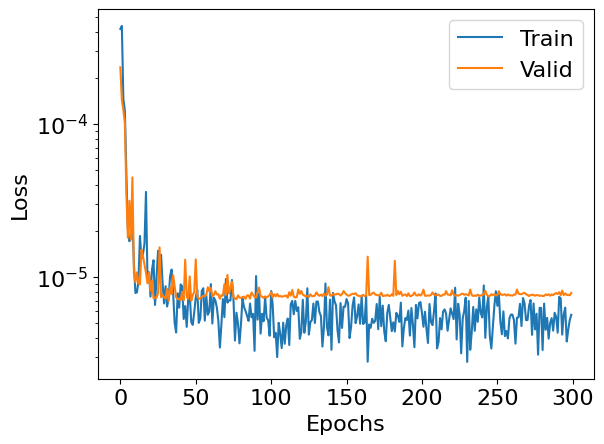

In [37]:
plt.plot(epochss, losses, label='Train')
plt.plot(epochss, val_losses, label='Valid')
plt.yscale('log')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [97]:
generator_test = genChunkFromRoot(filepath, 10000, noisefreqpersqmm=1e3)

In [43]:
net.load_state_dict(best_model_state)

<All keys matched successfully>

    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
    Generate noise with DCR per mm^2 0, mean number of hits per event: 0.00.
Average Test Loss: 5.994598495817627e-06
    Generate noise with DCR per mm^2 1000.0, mean number of hits per event: 4.03.
    Generate noise with DCR per mm^2 1000.0, mean number of hits per event: 4.03.
    Generate noise with D

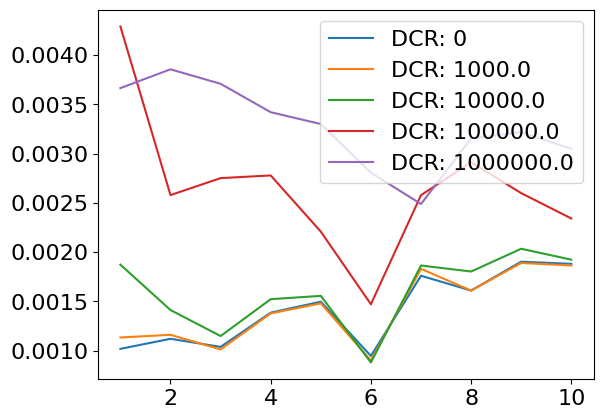

In [44]:
net.eval()
dcrs = [0, 1e3, 1e4, 1e5, 1e6]
sigms = np.zeros((len(dcrs), 10))
for num, dcr in enumerate(dcrs):
    test_loss = 0
    test_len = 0

    for _ in range(10):
        edf_test = next(genChunkFromRoot(filepath, 10000, noisefreqpersqmm=dcr))
        print('')
        edf_test = edf_test[edf_test.theta_p < 10 / 180 * np.pi]
        test_loader = prepare_data(edf_test, -1, False)
        recoAngles(edf_test, idf)
        edf_test = applySpaceCut(edf_test)
        planeRecalculation(edf_test, idf)
        planeRotation(edf_test)
        edf_test = applySecondSpaceCut(edf_test)
        primaryDirectionRecalculation(edf_test)
        recoAngles(edf_test, idf, rotation_mode=True)
        mask = np.logical_and(edf_test.rotated_r_c >= 16, edf_test.rotated_r_c <= 80)
        edf_test = edf_test[mask]

        with torch.no_grad():
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = net(test_inputs)
                test_loss += criterion(test_outputs, test_targets[:, None]).item()

        test_len += len(test_loader)

        out = np.array(test_outputs.cpu())
        inp = np.array(test_targets.cpu())
        dif = inp - out[:, 0]
        con = np.column_stack((beta_groups(edf_test), dif))
        res = pd.DataFrame()
        res['group'] = beta_groups(edf_test)
        res['dif'] = dif
        # sigms = []
        for group in range(1, 11):
            sub = res[res.group == group]
            std = rms90(sub.dif)
            sigms[num][group - 1] += std
            # sigms.append(std)

    sigms[num] = sigms[num] / 10
    plt.plot(np.linspace(1, 10, 10), sigms[num], label=f'DCR: {dcr}')
    average_test_loss = test_loss / test_len
    print(f'Average Test Loss: {average_test_loss}')
plt.legend()
plt.show()

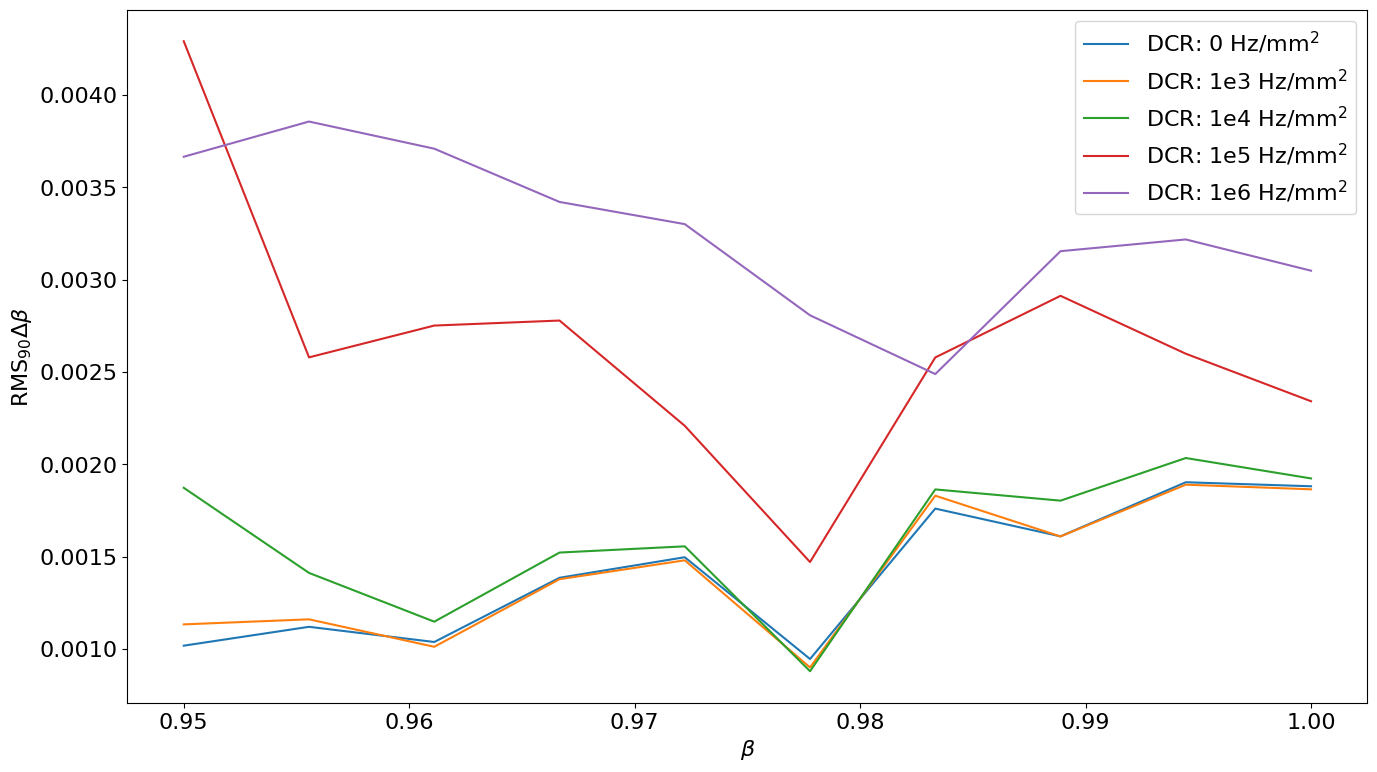

In [70]:
plt.figure(figsize=(16, 9))
dcrs = ['0', '1e3', '1e4', '1e5', '1e6']

for num, dcr in enumerate(dcrs):
    plt.plot(np.linspace(0.95, 1, 10), sigms[num], label=f'DCR: {dcr} Hz/mm'+r'$^2$')
plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'RMS$_{90}\Delta\beta$')
plt.show()

In [45]:
out

array([[0.9990251 ],
       [0.9920403 ],
       [0.998292  ],
       [0.99830437],
       [1.000714  ],
       [0.98433614],
       [1.0055783 ],
       [0.9954428 ],
       [0.985807  ],
       [0.9908807 ],
       [0.9990021 ],
       [1.0065912 ],
       [0.996122  ],
       [0.9965557 ],
       [1.0045464 ],
       [1.0013866 ],
       [0.9998388 ],
       [1.0062404 ],
       [0.99372876],
       [0.99771786],
       [1.0026138 ],
       [0.9941413 ],
       [0.9925008 ],
       [0.99639606],
       [1.0015544 ],
       [1.0024238 ],
       [0.99396527],
       [0.99853206],
       [1.0000048 ],
       [0.9996563 ],
       [0.99639654],
       [0.9992678 ],
       [0.99435884],
       [1.0063651 ],
       [1.0000883 ],
       [0.999025  ],
       [1.008552  ],
       [1.0087792 ],
       [0.9939306 ],
       [0.99757206],
       [0.996925  ],
       [0.99595547],
       [0.9985088 ],
       [0.99413216],
       [0.9955678 ],
       [0.9999546 ],
       [0.99523574],
       [0.990

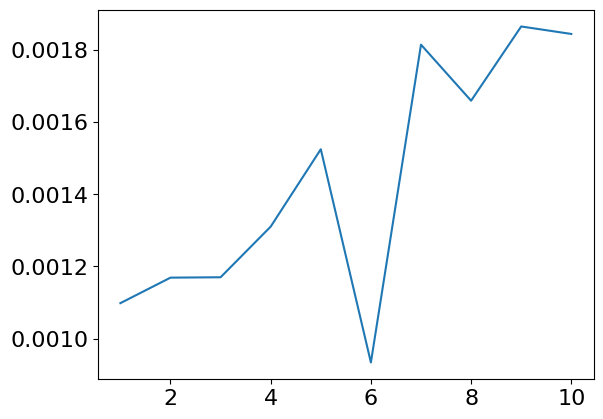

In [99]:
plt.plot(np.linspace(1, 10, 10), sigms)
plt.show()

In [139]:
test_outputs.shape

torch.Size([519, 1])

In [140]:
test_targets[:, None].shape

torch.Size([519, 1])

In [182]:
out

array([[0.9728248 ],
       [0.9653573 ],
       [0.9970181 ],
       [0.9717928 ],
       [0.9810436 ],
       [0.98985934],
       [0.96763206],
       [0.9728248 ],
       [0.9580852 ],
       [0.9740752 ],
       [0.9792695 ],
       [0.97257316],
       [0.9667032 ],
       [0.97331274],
       [0.97310543],
       [0.9932128 ],
       [0.9650738 ],
       [0.9895052 ],
       [0.9772314 ],
       [0.99142826],
       [0.9950142 ],
       [0.9637047 ],
       [0.9835563 ],
       [0.98974955],
       [0.99717367],
       [0.9976499 ],
       [0.9776484 ],
       [0.97322345],
       [0.9878497 ],
       [0.9728248 ],
       [0.9783175 ],
       [0.9890176 ],
       [0.9789156 ],
       [0.99074006],
       [0.98820484],
       [0.9829658 ],
       [0.9879782 ],
       [0.97816634],
       [0.98128676],
       [0.97051597],
       [0.99211323],
       [0.9944855 ],
       [0.99439085],
       [0.98072624],
       [0.968457  ],
       [0.9968145 ],
       [0.9885751 ],
       [0.961

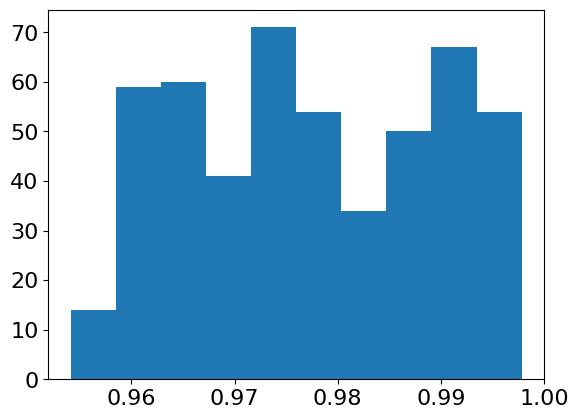

In [183]:
plt.hist(out, bins='auto')
plt.show()

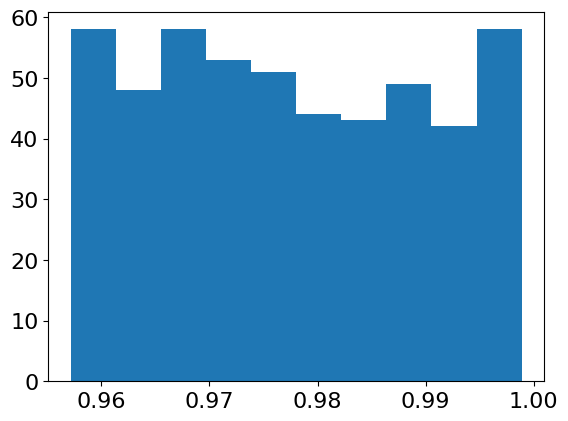

In [185]:
plt.hist(inp, bins='auto')
plt.show()

In [29]:
dif

array([1.5041196, 1.5177407, 1.4944764, 1.5144048, 1.4914489, 1.4953101,
       1.5218291, 1.515668 , 1.5214419, 1.4955174, 1.4879036, 1.4960828,
       1.516508 , 1.5114295, 1.5060674, 1.5007493, 1.4903965, 1.5167513,
       1.4885361, 1.4973204, 1.4975748, 1.5061307, 1.5238916, 1.5267804,
       1.5146   , 1.5165142, 1.5202062, 1.5073128, 1.4929638, 1.5199132,
       1.5187926, 1.48716  , 1.4973693, 1.5129483, 1.5193112, 1.522248 ,
       1.52307  , 1.5060124, 1.4875871, 1.5250344, 1.4910163, 1.4916477,
       1.5047197, 1.5020754, 1.5101767, 1.5225884, 1.5061951, 1.5236906,
       1.4943422, 1.488625 , 1.5101585, 1.524066 , 1.5125585, 1.5110881,
       1.4988946, 1.489832 , 1.495542 , 1.5011785, 1.5134656, 1.5072234,
       1.5201299, 1.5001063, 1.5159292, 1.5241064, 1.5082135, 1.5132539,
       1.5008339, 1.5112115, 1.5201683, 1.5272992, 1.5263228, 1.5169914,
       1.4916816, 1.5275531, 1.5037465, 1.4921762, 1.501318 , 1.5279279,
       1.4934931, 1.52269  , 1.5190581, 1.4960808, 

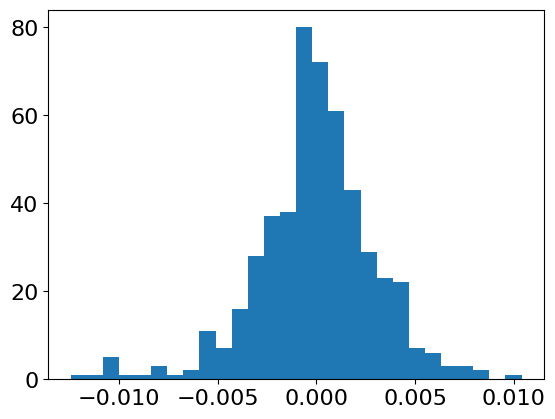

In [186]:
plt.hist(dif, bins='auto')
plt.show()

In [ ]:
edf_test = next(generator)

In [ ]:
edf_test = edf_test[edf_test.theta_p < 10 / 180 * np.pi]

In [ ]:
edf_test.shape

In [ ]:
test_loader = prepare_data(edf_test, -1, False)

In [ ]:
net.eval()
test_loss = 0

with torch.no_grad():
    for test_inputs, test_targets in test_loader:
        test_outputs = net(test_inputs)
        test_loss += criterion(test_outputs, test_targets).item()

# Calculate the average test loss
average_test_loss = test_loss / len(test_loader)

print(f'Average Test Loss: {average_test_loss}')

In [ ]:
test_outputs.shape

In [ ]:
beta_groups(edf_test)

In [ ]:
out = np.array(test_outputs)

In [ ]:
inp = np.array(test_targets)

In [ ]:
dif = inp - out[:,0]

In [ ]:
con = np.column_stack((beta_groups(edf_test), dif))

In [ ]:
res = pd.DataFrame()

In [ ]:
res['group'] = beta_groups(edf_test)
res['dif'] = dif

In [ ]:
sigms = []
for group in range(1, 11):
    sub = res[res.group == group]
    std = rms90(sub.dif)
    sigms.append(std)

In [ ]:
plt.plot(np.linspace(1, 10, 10), sigms)
plt.show()

cosmos


In [70]:
mass = 1.98892 * 1e30

radius = 149.6 * 1e9
grav = 6.6743 * 1e-11
# omega = -3 / 2
omega = -1.03
P = 2 * np.pi * np.sqrt(radius ** 3 / (grav * mass))
milky_P = 212 * 1e6 * 365.25 * 24 * 60 * 60
cluster_P = 2 * np.pi * np.sqrt((86 * 9.461e15) ** 3 / (grav * 4.05 * 1e6 * mass))
sun_P = 365.25 * 24 * 60 * 60
earth_P =  2 * np.pi * np.sqrt((6371 * 1e3) ** 3 / (grav * 5.9726 * 1e24))
atom_P = 1.15 * 1e-16
nucleus_P = 2 * np.pi * 1e-14 / 1e7
t = atom_P * np.sqrt(2 * np.abs(1 + 3 * omega)) / (6 * np.pi * np.abs(1 + omega))
# print(P / 60 / 60 / 24)
# print(t)
print(t / 60 / 60 / 24 / 365.25 / 1e9, ' GY')
print(t / 60 / 60 / 24 / 365.25 / 1e6, ' MY')
print(t / 60 / 60 / 24 / 365.25, ' Years')
print(t / 60 / 60 / 24 / 365.25 * 12, ' Months')
print(t / 60 / 60 / 24, ' Days')
print(t / 60 / 60, ' Hours')
print(t / 60, ' Minutes')
print(t, ' Seconds')

1.31752734102788e-32  GY
1.31752734102788e-29  MY
1.31752734102788e-23  Years
1.581032809233456e-22  Months
4.812268613104332e-21  Days
1.1549444671450397e-19  Hours
6.929666802870238e-18  Minutes
4.157800081722143e-16  Seconds
